# Preparations

Imports

In [1]:
import random
import numpy as np

import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.optim as optim

import wandb

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import os
import zipfile
from tqdm.notebook import tqdm
import time
import cv2
import shutil

# !pip -q install -U fvcore
from fvcore.nn import FlopCountAnalysis #, flop_count_table

from dataclasses import dataclass
from typing import Tuple

import warnings
warnings.filterwarnings(action='ignore')

## Utils

### Label-color correlator

In [2]:
@dataclass
class GTA5Label:
    name: str
    ID: int
    color: Tuple[int, int, int]

class GTA5Labels_TaskCV2017():
    road = GTA5Label(name = "road", ID=0, color=(128, 64, 128))
    sidewalk = GTA5Label(name = "sidewalk", ID=1, color=(244, 35, 232))
    building = GTA5Label(name = "building", ID=2, color=(70, 70, 70))
    wall = GTA5Label(name = "wall", ID=3, color=(102, 102, 156))
    fence = GTA5Label(name = "fence", ID=4, color=(190, 153, 153))
    pole = GTA5Label(name = "pole", ID=5, color=(153, 153, 153))
    light = GTA5Label(name = "light", ID=6, color=(250, 170, 30))
    sign = GTA5Label(name = "sign", ID=7, color=(220, 220, 0))
    vegetation = GTA5Label(name = "vegetation", ID=8, color=(107, 142, 35))
    terrain = GTA5Label(name = "terrain", ID=9, color=(152, 251, 152))
    sky = GTA5Label(name = "sky", ID=10, color=(70, 130, 180))
    person = GTA5Label(name = "person", ID=11, color=(220, 20, 60))
    rider = GTA5Label(name = "rider", ID=12, color=(255, 0, 0))
    car = GTA5Label(name = "car", ID=13, color=(0, 0, 142))
    truck = GTA5Label(name = "truck", ID=14, color=(0, 0, 70))
    bus = GTA5Label(name = "bus", ID=15, color=(0, 60, 100))
    train = GTA5Label(name = "train", ID=16, color=(0, 80, 100))
    motocycle = GTA5Label(name = "motocycle", ID=17, color=(0, 0, 230))
    bicycle = GTA5Label(name = "bicycle", ID=18, color=(119, 11, 32))
    void = GTA5Label(name = "void", ID=255, color=(0,0,0))

    list_ = [
        road,
        sidewalk,
        building,
        wall,
        fence,
        pole,
        light,
        sign,
        vegetation,
        terrain,
        sky,
        person,
        rider,
        car,
        truck,
        bus,
        train,
        motocycle,
        bicycle,
        void
    ]

### Functions

In [ ]:
def pretty_extract(zip_path:str, extract_to:str) -> None:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        png_files = [f for f in zip_ref.namelist() if f.endswith('.png')]

        for file in tqdm(png_files, desc="Extracting PNGs"):
            zip_ref.extract(file, path=extract_to)

def poly_lr_scheduler(optimizer, init_lr:float, iter:int=0, lr_decay_iter:int=1, max_iter:int=50, power:float=0.9) -> float:
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """
    if ((iter % lr_decay_iter) != 0) or iter > max_iter:
        return optimizer.param_groups[0]['lr']

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    return lr

def fast_hist(a:np.ndarray, b:np.ndarray, n:int) -> np.ndarray:
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def fast_hist_cuda(a: torch.Tensor, b: torch.Tensor, n: int) -> torch.Tensor:
    """
    a and b are label and prediction respectively.
    n is the number of classes.
    This version works with CUDA tensors.
    """
    k = (a >= 0) & (a < n)
    a = a[k].to(torch.int64)
    b = b[k].to(torch.int64)

    indices = n * a + b

    hist = torch.zeros(n * n, dtype=torch.float32, device=a.device)

    hist.scatter_add_(0, indices, torch.ones_like(indices, dtype=torch.float32))

    return hist.view(n, n)

def per_class_iou(hist:np.ndarray) -> np.ndarray:
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

def per_class_iou_cuda(hist:torch.Tensor) -> torch.Tensor:
    epsilon = 1e-5
    diag = torch.diag(hist)

    sum_rows = hist.sum(dim=1)
    sum_cols = hist.sum(dim=0)

    iou = diag / (sum_rows + sum_cols - diag + epsilon)
    return iou

# Mapping labelId image to RGB image
def decode_segmap(mask:np.ndarray) -> np.ndarray:
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label_id in GTA5Labels_TaskCV2017().list_:
        color_mask[mask == label_id.ID, :] = label_id.color

    return color_mask

def tensorToImageCompatible(t:torch.Tensor) -> np.ndarray:
    """
    convert from a tensor of shape [C, H, W] where a normalization has been applied
    to an unnormalized tensor of shape [H, W, C],
    so *plt.imshow(tensorToImageCompatible(tensor))* works as expected.\n
    Intended to be used to recover the original element
    when this transformation is used:
    - transform = v2.Compose([
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])])
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view([-1, 1, 1])
    std = torch.tensor([0.229, 0.224, 0.225]).view([-1, 1, 1])

    unnormalized = t * std + mean

    return (unnormalized.permute(1,2,0).clamp(0,1).numpy()*255).astype(np.uint8)


def log_confusion_matrix(title:str, hist:np.ndarray, tag:str, step_name:str, step_value:int):
    row_sums = hist.sum(axis=1, keepdims=True)
    safe_hist = np.where(row_sums == 0, 0, hist / row_sums)

    plt.figure(figsize=(10, 8))
    sns.heatmap(100.*safe_hist, fmt=".2f", annot=True, cmap="Blues", annot_kws={'size': 7})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)

    wandb.log({tag: wandb.Image(plt), step_name:step_value})
    plt.close()

def log_bar_chart_ioU(title:str, class_names:list, mIou:float, iou_class:np.ndarray, tag:str, step_name:str, epoch:int):
    iou_percent = [round(iou*100., 2) for iou in iou_class]
    miou_percent = round(mIou*100., 2)

    all_labels = ["mIoU"] + class_names
    all_values = [miou_percent] + iou_percent

    plt.figure(figsize=(14, 5))
    bars = plt.bar(range(len(all_values)), all_values, color='skyblue')
    plt.xticks(range(len(all_labels)), all_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 1, f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

    plt.ylabel("IoU (%)")
    plt.ylim(0, 105)
    plt.title(title)
    plt.tight_layout()

    wandb.log({tag: wandb.Image(plt), step_name:epoch})

    plt.close()

def num_flops(device, model:torch.nn.Module, H:int, W:int):
    model.eval()
    img = (torch.zeros((1,3,H,W), device=device),)

    flops = FlopCountAnalysis(model, img)
    # return flop_count_table(flops)
    return flops.total()/1e9

def num_param(model: torch.nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6

def latency(device, model:torch.nn.Module, H:int, W:int):
    model.eval()

    img = torch.zeros((1,3,H,W)).to(device)
    iterations = 1000
    latency_list = []
    FPS_list  = []

    with torch.no_grad():
        for _ in tqdm(range(iterations)):
            start_time = time.time()
            _ = model(img)
            end_time = time.time()

            latency = end_time - start_time

            if latency > 0.0:
                latency_list.append(latency)
                FPS_list.append(1.0/latency)

    mean_latency = np.mean(latency_list)*1000
    std_latency = np.std(latency_list)*1000
    mean_FPS = np.mean(FPS_list)

    return mean_latency, std_latency, mean_FPS

class RandomCrop:
    def __init__(self, size):
        self.size = tuple(size)

    def __call__(self, imgs, labels):
        B, C, H, W = imgs.size()
        th, tw = self.size

        imgs_cropped = []
        labels_cropped = []

        for i in range(B):
            x1 = random.randint(0, W - tw)
            y1 = random.randint(0, H - th)

            imgs_cropped.append(
                v2.functional.crop(imgs[i], y1, x1, th, tw)
            )

            if labels is not None:
                labels_cropped.append(
                    v2.functional.crop(labels[i], y1, x1, th, tw)
                )

        imgs_cropped = torch.stack(imgs_cropped)

        if labels is not None:
            labels_cropped = torch.stack(labels_cropped)
            return imgs_cropped, labels_cropped
        else:
            return imgs_cropped, None

def display_result_of_mixing(uleft, ucenter, uright, lleft, lcenter, lright):
    fig = plt.figure(figsize=(15,10))
    axs = fig.subplots(2, 3)

    axs[0, 0].imshow(tensorToImageCompatible(uleft))
    axs[0, 1].imshow(tensorToImageCompatible(ucenter))
    axs[0, 2].imshow(tensorToImageCompatible(uright))

    axs[1, 0].imshow(decode_segmap(lleft))
    axs[1, 1].imshow(decode_segmap(lcenter))
    axs[1, 2].imshow(decode_segmap(lright))

    fig.show()
    
def FDA(src_img: torch.Tensor, tgt_img: torch.Tensor, beta: float = 0.01) -> torch.Tensor:
    # FFT2 is applied to each of the 3 RGB channels
    # src_img: torch Tensor [3, H, W ]
    # tgt_img: torch Tensor [3, H, W ]

    fft_src = torch.fft.fft2(src_img, dim=(-2, -1))
    fft_tgt = torch.fft.fft2(tgt_img, dim=(-2, -1))

    fft_src_shift = torch.fft.fftshift(fft_src, dim=(-2, -1))
    fft_tgt_shift = torch.fft.fftshift(fft_tgt, dim=(-2, -1))
    
    _, H, W = src_img.shape
    c_h, c_w = H // 2, W // 2
    bH = int(beta * H/2)
    bW = int(beta * W/2)

    mask = torch.zeros_like(fft_src.real, dtype=torch.bool)
    mask[:, c_h - bH:c_h + bH, c_w - bW:c_w + bW] = True

    amplitude_src = torch.abs(fft_src_shift)
    phase_src = torch.angle(fft_src_shift)
    amplitude_tgt = torch.abs(fft_tgt_shift)

    a = torch.fft.ifftshift(
        torch.where(mask, amplitude_tgt, amplitude_src)* torch.exp(1j * phase_src), 
        dim=(-2, -1)
    )

    res = torch.fft.ifft2(a, dim=(-2, -1)).real.clamp(0, 1)

    return res 

def FDA_normalization(src_img: torch.Tensor, tgt_img: torch.Tensor, beta: float = 0.01, n: int = 1,
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    This functions applied the Fourier trasformation to the source domain
    with respect to the target domain
    Then to both the Tensor is applied data augmentation and normalization
    ATTENTION: for FDA it is necessary that both the images have the same high and width

    Inputs:
    - src_img: torch Tensor [B, 3, H, W ] from the source domain
    - tgt_img: torch Tensor [B//n, 3, H, W ] from the target domain
    - beta: coefficient for the mask of the FDA
    - n: ratio between the number of images of the batch of the source and target domain
    - mean, std: necessary for the normalization

    Outputs:
    - src_img_aug <- augmentation to src_img_fda <- FDA to src_img
    - tgt_img_aug <- augmentation to tgt_img

    """
    global device
    normalization = TF.Normalize(mean=mean, std=std)

    # FDA
    B, _, H, W = src_img.shape
    c_h, c_w = H // 2, W // 2
    bH = int(beta * H)
    bW = int(beta * W)
    tgt_img_r = tgt_img.repeat(B//n, 1, 1, 1)[:B]

    fft_src = torch.fft.fft2(src_img, dim=(-2, -1)).to(device)
    fft_tgt = torch.fft.fft2(tgt_img_r, dim=(-2, -1)).to(device)

    fft_src_shift = torch.fft.fftshift(fft_src, dim=(-2, -1))
    fft_tgt_shift = torch.fft.fftshift(fft_tgt, dim=(-2, -1))

    mask = torch.zeros_like(fft_src).real.to(device)
    mask[:, :, c_h - bH:c_h + bH, c_w - bW:c_w + bW] = 1
    mask = mask > 0.5

    amplitude_src = torch.abs(fft_src_shift).to(device)
    phase_src = torch.angle(fft_src_shift).to(device)
    amplitude_tgt = torch.abs(fft_tgt_shift).to(device)

    # fft_src = amplitude_src * exp(1j * phase_src)

    a = torch.fft.ifftshift(torch.where(mask, amplitude_tgt, amplitude_src)* torch.exp(1j * phase_src), dim=(-2, -1)).to(device)
    src_img_fda = torch.fft.ifft2(a, dim=(-2, -1)).real.clamp(0, 1).to(device)

    # Normalization
    src_img_norm = normalization(src_img_fda.to(device))
    tgt_img_norm = normalization(tgt_img.to(device))

    return src_img_norm.detach(), tgt_img_norm.detach()
    # return src_img_fda, tgt_img.to(device)

class ClassMixer():
    def __init__(self, n_classes:int, selected_portion:float, device):
        self.n_classes = n_classes
        self.device = device
        self.selected_portion = selected_portion
    
    def __call__(self, source_imgs, target_imgs, source_labels, target_pseudo_labels):
        B = source_labels.size(0)
        
        mask = torch.zeros_like(source_labels, dtype=torch.bool, requires_grad=False, device=self.device)

        for i in range(B):
            present_classes = torch.unique(source_labels[i])
            num_select = max(1, int(len(present_classes)*self.selected_portion))
            selected_classes = present_classes[torch.randperm(len(present_classes))[:num_select]]

            mask[i] = torch.isin(source_labels[i], selected_classes)
        
        mask_img = mask.unsqueeze(1).expand_as(source_imgs)
        
        mixed_img = torch.where(mask_img, source_imgs, target_imgs)
        mixed_label = torch.where(mask, source_labels, target_pseudo_labels)

        return mixed_img, mixed_label


### Variables

#### Dataset settings

In [ ]:
randomcrop = RandomCrop((512, 1024))

s = 0.6
source_augmentation = v2.Compose([
    v2.RandomApply([v2.GaussianBlur(7)],p=0.5),
    v2.RandomApply([v2.ColorJitter(brightness=s, contrast=s, saturation=s, hue=0.1)],p=0.5),
    # v2.RandomApply([v2.GaussianNoise(mean=0.0, sigma=0.4)],p=0.5)
])

s = 0.1
target_augmentation = v2.Compose([
    v2.RandomApply([v2.GaussianBlur(3)],p=0.5),
    v2.RandomApply([v2.ColorJitter(brightness=s, contrast=s, saturation=s, hue=s)],p=0.5),
    # v2.RandomApply([v2.GaussianNoise(mean=0.0, sigma=0.03)],p=0.5)
])

s = 0.25
mixed_augmentation = target_augmentation = v2.Compose([
    v2.RandomApply([v2.GaussianBlur(7)],p=0.5),
    v2.RandomApply([v2.ColorJitter(brightness=s, contrast=s, saturation=s, hue=s)],p=0.5),
    # v2.RandomApply([v2.GaussianNoise(mean=0.0, sigma=0.03)],p=0.5)
])

source_augmentation = nn.Identity()
target_augmentation = nn.Identity()
mixed_augmentation = nn.Identity()


resolution_source_dataset = (720, 1280)
resolution_target_dataset = (512, 1024)

toTensor = v2.ToTensor()
normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

img_transform_target = v2.Compose([
    toTensor,
    v2.Resize(resolution_target_dataset),
    # normalize
])

img_transform_target_normalized = v2.Compose([
    toTensor,
    v2.Resize(resolution_target_dataset),
    normalize
])

label_transform_target = v2.Compose([
    toTensor,
    v2.Resize(resolution_target_dataset, interpolation=v2.InterpolationMode.NEAREST),
])

img_transform_source = v2.Compose([
    toTensor,
    v2.Resize(resolution_source_dataset),
    # normalize
])

label_transform_source = v2.Compose([
    toTensor,
    v2.Resize(resolution_source_dataset, interpolation=v2.InterpolationMode.NEAREST),
])


#### Logging

In [5]:
ENABLE_PRINT = False
ENABLE_WANDB_LOG = True
log_per_epoch = 20
n_classes = 19

train_step = 0
val_step = 0

#### Device

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(device)

cuda


# Downloads

## CityScapes download

In [33]:
# !pip install -q gdown

# file_id = "1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O"
# !gdown https://drive.google.com/uc?id={file_id}

# pretty_extract("Cityscapes.zip", ".")


## GTA5 download

In [34]:
# !pip install -q gdown

# file_id = "1PWavqXDxuifsyYvs2PFua9sdMl0JG8AE"
# !gdown https://drive.google.com/uc?id={file_id}

# pretty_extract("Gta5_extended.zip", "./Gta5_extended")

## DeepLabV2 model weights

In [35]:
# !pip install -q gdown

# file_id = "1KgYgBTmvq7UcBwKui2b4TomnbTmzJMBf"
# !gdown https://drive.google.com/uc?id={file_id}

# Dataset

## Cityscapes

In [7]:
class CityScapes(Dataset):
    def __init__(self, rootdir, split="train", targetdir="gtFine", imgdir="images", transform=None, target_transform=None):
        super(CityScapes, self).__init__()

        self.rootdir = rootdir
        self.split = split
        self.targetdir = os.path.join(self.rootdir, targetdir, self.split) # ./gtFine/train/
        self.imgdir = os.path.join(self.rootdir, imgdir, self.split) # ./images/train/
        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for city in os.listdir(self.imgdir): # frankfurt
            img_city_dir = os.path.join(self.imgdir, city) # ./images/train/frankfurt/
            target_city_dir = os.path.join(self.targetdir, city) # ./gtFine/train/frankfurt/

            for img_path in os.listdir(img_city_dir): # frankfurt_000000_000294_leftImg8bit.png
                if img_path.endswith(".png"):
                  self.imgs_path.append(os.path.join(img_city_dir, img_path)) # ./images/train/frankfurt/frankfurt_000000_000294_leftImg8bit.png

                  target_color_path = img_path.replace("leftImg8bit", "gtFine_color") # frankfurt_000000_000294_gtFine_color.png
                  target_labelIds_path = img_path.replace("leftImg8bit", "gtFine_labelTrainIds") # frankfurt_000000_000294_gtFine_labelTrainIds.png

                  self.targets_color_path.append(os.path.join(target_city_dir, target_color_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_color.png
                  self.targets_labelIds_path.append(os.path.join(target_city_dir, target_labelIds_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')
        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')
        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED).astype(np.int64)
        
        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path)


## GTA5

In [8]:
class GTA5(Dataset):
    def __init__(self, rootdir, file_names, imgdir="images", targetdir="labels", augment=False, transform=None, target_transform=None):
        super(GTA5, self).__init__()

        self.to_tensor = v2.ToTensor()
        self.to_pil = v2.ToPILImage()

        self.gaussian_blur = v2.GaussianBlur(7)

        s = 0.6
        self.color_jitter = v2.ColorJitter(brightness=s, contrast=s, saturation=s, hue=0.1)
        self.gaussian_noise = v2.GaussianNoise(mean=0.0, sigma=0.4)
    
        self.augmentations = {
            self.gaussian_blur: 0.5,
            self.color_jitter: 0.5,
            self.gaussian_noise: 0.5
        }

        self.rootdir = rootdir

        self.targetdir = os.path.join(self.rootdir, targetdir) # ./labels
        self.imgdir = os.path.join(self.rootdir, imgdir) # ./images

        self.augment = augment

        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for image_file in file_names: # 00001.png
            self.imgs_path.append(os.path.join(self.imgdir, image_file)) #./images/00001.png

            target_color_path = image_file # 00001.png
            target_labelsId_path = image_file.split(".")[0]+"_labelIds.png" # 00001_labelIds.png

            self.targets_color_path.append(os.path.join(self.targetdir, target_color_path)) #./labels/00001.png
            self.targets_labelIds_path.append(os.path.join(self.targetdir, target_labelsId_path)) #./labels/00001_labelIDs.png

    def create_target_img(self):
        list_ = GTA5Labels_TaskCV2017().list_

        for i, img_path in tqdm(enumerate(self.targets_color_path)):
            image_numpy = np.asarray(Image.open(img_path).convert('RGB'))

            H, W, _ = image_numpy.shape
            label_image = 255*np.ones((H, W), dtype=np.uint8)

            for label in list_:
                label_image[(image_numpy == label.color).all(axis=-1)] = label.ID

            new_img = Image.fromarray(label_image)
            new_img.save(self.targets_labelIds_path[i])

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')
        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')
        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED).astype(np.int64)

        if self.augment:
            image, target_color, target_labelIds = self.augment_data(image, target_color, target_labelIds)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path)

    def augment_data(self, image, target_color, target_labelIds):
        image = self.to_tensor(image)

    # Geometric Transformations
        # Horizontal Flip
        # img_tensor = v2.functional.hflip(img_tensor)
        # target_color = np.fliplr(target_color).copy()
        # target_labelIds = np.fliplr(target_labelIds).copy()

        for augmentation, p in self.augmentations.items():
            if random.random() < p:
                image = augmentation(image)

        image = torch.clamp(image, 0.0, 1.0)
        image = self.to_pil(image)

        return image, target_color, target_labelIds


def GTA5_dataset_splitter(rootdir, train_split_percent, split_seed = None, imgdir="images", targetdir="labels", augment=False, transform=None, target_transform=None):
    assert 0.0 <= train_split_percent <= 1.0, "train_split_percent should be a float between 0 and 1"

    target_path = os.path.join(rootdir, targetdir) # ./labels
    img_path = os.path.join(rootdir, imgdir) # ./images

    file_names = [
        f for f in os.listdir(img_path)
        if f.endswith(".png") and os.path.exists(os.path.join(target_path, f.split(".")[0]+"_labelIds.png"))
    ]

    if split_seed is not None:
        random.seed(split_seed)
    random.shuffle(file_names)
    random.seed()

    split_idx = int(len(file_names) * train_split_percent)

    train_files = file_names[:split_idx]
    val_files = file_names[split_idx:]

    return GTA5(rootdir, train_files, imgdir, targetdir, augment, transform, target_transform), \
           GTA5(rootdir, val_files, imgdir, targetdir, False, transform, target_transform)


# Model

## Bisenet

In [ ]:
class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.spatial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.spatial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def encode(self, input):
        # output of spatial path
        sx = self.spatial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)     

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)
        
        return result, cx1, cx2
    
    def decode(self, result):
        # upsampling
        # result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        return result        

    def forward(self, input):
        fused_features, cx1, cx2 = self.encode(input)
        out = self.decode(fused_features)

        if self.training:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = F.interpolate(cx1_sup, size=input.shape[2:], mode='bilinear', align_corners=False)
            cx2_sup = F.interpolate(cx2_sup, size=input.shape[2:], mode='bilinear', align_corners=False)
            return out, cx1_sup, cx2_sup

        return out   

import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionFusion(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_channels=None):
        super().__init__()
        self.query_proj = nn.Conv2d(in_channels, hidden_dim, 1)
        self.key_proj = nn.Conv2d(in_channels, hidden_dim, 1)
        self.value_proj = nn.Conv2d(in_channels, in_channels, 1)
        # self.out_proj = nn.Conv2d(hidden_dim, out_channels or in_channels, 1)

        self.query_downsample = None # or nn.AvgPool2d(kernel_size=4, stride=4)
        self.key_downsample =   None # or nn.AvgPool2d(kernel_size=4, stride=4)

    def forward(self, query_feats, key_feats):
        """
        Args:
            query_feats: high-resolution features (e.g. cropped HR image)
            key_feats: low-resolution context (e.g. same crop from LR image)
        Returns:
            Attention-weighted HR features
        """
        B = query_feats.size(0)

        query = self.query_proj(query_feats)
        if self.query_downsample is not None:
            query = self.query_downsample(query)
    
        _, _, H, W = query.shape
        query = query.reshape(B, -1, H*W).permute(0, 2, 1)  # (B, H*W, dim)
        
        key = self.key_proj(key_feats)
        value = self.value_proj(key_feats)
        if self.key_downsample is not None:
            key = self.key_downsample(key)
            value = self.key_downsample(value)
            
        key = key.reshape(B, -1, H*W)                        # (B, dim, H*W)
        value = value.reshape(B, -1, H*W).permute(0, 2, 1)  # (B, H*W, dim)
       
        attn = torch.bmm(query, key) / (key.shape[1] ** 0.5)                    # (B, H*W, H*W)
        attn = F.softmax(attn, dim=-1)

        context = torch.bmm(attn, value)                                        # (B, H*W, dim)
        context = context.permute(0, 2, 1).reshape(B, -1, H, W)
        # out = self.out_proj(context)

        if self.query_downsample is not None:
            return nn.functional.interpolate(context, scale_factor=4, mode='bilinear', align_corners=False)
        return context
    
class BiSeNetWithHRDA(BiSeNet):
    def __init__(self, num_classes, context_path, s):
        super().__init__(num_classes, context_path)
        self.scale_factor = s
        self.attentionmodule = AttentionFusion(in_channels=self.conv.out_channels, hidden_dim=16)

    def hrda_crop(self, img:torch.Tensor, label=None) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, tuple[int,int,int,int]]:
        """
        Crop a high-res patch and return both full LR and cropped HR image + label if provided.
        """
        _, _, H, W = img.shape
        ch, cw = int(H*self.scale_factor), int(W*self.scale_factor) 

        lr_img = nn.functional.interpolate(img, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)
        lr_label = nn.functional.interpolate(label.float(), scale_factor=self.scale_factor, mode='nearest') if label is not None else None
        
        x1 = random.randint(0, W - cw)
        y1 = random.randint(0, H - ch)

        hr_img = img[:, :, y1:y1+ch, x1:x1+cw]
        hr_label = label[:, y1:y1+ch, x1:x1+cw] if label is not None else None

        return lr_img, lr_label, hr_img, hr_label, (x1, y1, cw, ch)

    def hrda_forward(self, lr_img, hr_img, crop_coords) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]: #, tuple[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor]]:
        """
        Full HRDA forward: low-res + high-res + fusion
        """

        # lr_img, lr_label, hr_img, hr_label, crop_coords = self.hrda_crop(img)

        lr_feat, _, _ = self.encode(lr_img.detach())
        hr_feat, _, _ = self.encode(hr_img.detach())

        fused = self.hrda_fuse(lr_feat, hr_feat, crop_coords)
        
        # fig, axs = plt.subplots(1, 3, figsize=(10,10))
        # axs[0].imshow(tensorToImageCompatible(lr_img[0].detach().cpu()))
        # axs[1].imshow(tensorToImageCompatible(hr_img[0].detach().cpu()))
        # axs[2].imshow(decode_segmap(
        #     torch.argmax(fused[0].detach().cpu(), dim=0).numpy()
        # )
        # )
        # fig.show()

        return self.decode(fused), (
            nn.functional.interpolate(
                self.decode(
                    lr_feat
                ),
                scale_factor=8./self.scale_factor, mode='bilinear', align_corners=False
            ),
            nn.functional.interpolate(
                self.decode(
                    hr_feat
                ), 
                scale_factor=8, mode='bilinear', align_corners=False
            )
            
        ) # , (lr_cx1, lr_cx2), (hr_cx1, hr_cx2)

    def hrda_fuse(self, lr_feat, hr_feat, crop_coords) -> torch.Tensor:
        """
        Overwrite or confidence-based fusion of HR patch into LR output.
        """
        x1, y1, cw, ch = crop_coords

        context = self.attentionmodule(lr_feat, lr_feat)

        lr_out = self.decode(lr_feat)
        hr_out = self.decode(hr_feat)

        fused = nn.functional.interpolate(lr_out, scale_factor=8./self.scale_factor, mode='bilinear', align_corners=False).clone()

        # Option 1: Attention
        hr_out *= context
        context = torch.nn.functional.interpolate(context, scale_factor=8, mode='bilinear')
        fused[:, :, y1:y1+ch, x1:x1+cw] *= (1-context)
        fused[:, :, y1:y1+ch, x1:x1+cw] += torch.nn.functional.interpolate(hr_out, scale_factor=8, mode='bilinear')


        #TODO: print attention to visually conferm since at epoch 1 you can physically see boundary

        # fig, axs = plt.subplots(1, 3, figsize=(10,10))
        # axs[0].imshow(context[0].mean(0).detach().cpu().numpy())
        # axs[1].imshow(decode_segmap( 
        #     torch.argmax(
        #         hr_out[0].detach().cpu(), dim=0
        #     ).numpy()
        # ))
        # axs[2].imshow(decode_segmap( 
        #     torch.argmax(
        #         lr_out[0].detach().cpu(), dim=0
        #     ).numpy()
        # ))
        # fig.show()


        # Option 2: Fized fusion
        # fused[:, :, y1:y1+ch, x1:x1+cw] = hr_out

        # Option 3: Confidence-weighted fusion
        # conf_hr, _ = torch.max(torch.softmax(hr_out, dim=1), dim=1, keepdim=True)
        # conf_lr, _ = torch.max(torch.softmax(fused[:, :, y1:y1+ch, x1:x1+cw], dim=1), dim=1, keepdim=True)
        # mask = conf_hr > conf_lr
        # fused[:, :, y1:y1+ch, x1:x1+cw] = torch.where(mask, hr_out, fused[:, :, y1:y1+ch, x1:x1+cw])

        return fused

    def hrda_eval(self, img):
        with torch.no_grad():
            lr_img, _, hr_img, _, crop_coords = self.hrda_crop(img)
            
            lr_out, _, _ = self.encode(lr_img.detach())
            hr_out, _, _ = self.encode(hr_img.detach())

            fused = self.hrda_fuse(lr_out, hr_out, crop_coords)

        return torch.nn.functional.interpolate(self.decode(fused), scale_factor=8, mode='bilinear')
    
    def hrda_loss(self, criterion, fused_out, label, lr_out, lr_label, hr_out, hr_label):
        # Loss calculation:
        loss_hr_source = criterion(hr_out, hr_label) # + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
        loss_lr_source = 0 # criterion(outputs_source, lr_label_src) # + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
        loss_fused_src = criterion(fused_out, label)

        lambda_d = 0.1
        loss = (1-lambda_d)*loss_fused_src+lambda_d*(loss_lr_source+loss_hr_source)
    
        return loss
    
    def hrda_loss_FDA(self, criterion, fused_out_src, fused_out_tgt, label, lr_out_src, lr_out_tgt, lr_label, hr_out_src, hr_out_tgt, hr_label):
        # Loss calculation:
        loss_hr_source = criterion(hr_out_src, hr_label, hr_out_tgt) # + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
        loss_lr_source = 0 # criterion(outputs_source, lr_label_src) # + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
        loss_fused_src = criterion(fused_out_src, label, fused_out_tgt)

        lambda_d = 0.1
        loss = (1-lambda_d)*loss_fused_src+lambda_d*(loss_lr_source+loss_hr_source)

        return loss


## DeepLabV2

In [10]:
affine_par = True

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine=affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class ClassifierModule(nn.Module):
    def __init__(self, inplanes, dilation_series, padding_series, num_classes):
        super(ClassifierModule, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(
                nn.Conv2d(inplanes, num_classes, kernel_size=3, stride=1, padding=padding,
                          dilation=dilation, bias=True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list) - 1):
            out += self.conv2d_list[i + 1](x)
        return out


class ResNetMulti(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNetMulti, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)  # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer6 = ClassifierModule(2048, [6, 12, 18, 24], [6, 12, 18, 24], num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if (stride != 1
                or self.inplanes != planes * block.expansion
                or dilation == 2
                or dilation == 4):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par))
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, H, W = x.size()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer6(x)

        x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')

        if self.training == True:
            return x, None, None

        return x

    def get_1x_lr_params_no_scale(self):
        """
        This generator returns all the parameters of the net except for
        the last classification layer. Note that for each batchnorm layer,
        requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
        any batchnorm parameter
        """
        b = []

        b.append(self.conv1)
        b.append(self.bn1)
        b.append(self.layer1)
        b.append(self.layer2)
        b.append(self.layer3)
        b.append(self.layer4)

        for i in range(len(b)):
            for j in b[i].modules():
                jj = 0
                for k in j.parameters():
                    jj += 1
                    if k.requires_grad:
                        yield k

    def get_10x_lr_params(self):
        """
        This generator returns all the parameters for the last layer of the net,
        which does the classification of pixel into classes
        """
        b = []
        if self.multi_level:
            b.append(self.layer5.parameters())
        b.append(self.layer6.parameters())

        for j in range(len(b)):
            for i in b[j]:
                yield i

    def optim_parameters(self, lr):
        return [{'params': self.get_1x_lr_params_no_scale(), 'lr': lr},
                {'params': self.get_10x_lr_params(), 'lr': 10 * lr}]


def get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='deeplab_resnet_pretrained_imagenet.pth'):
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes)

    # Pretraining loading
    if pretrain:
        print('Deeplab pretraining loading...')
        saved_state_dict = torch.load(pretrain_model_path)

        new_params = model.state_dict().copy()
        for i in saved_state_dict:
            i_parts = i.split('.')
            new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
        model.load_state_dict(new_params, strict=False)

    return model


# Train/Val loops

## Train Loop

### Train step 3

In [11]:
def train3(model:nn.Module, train_loader:DataLoader, criterion:nn.Module, optimizer:optim.Optimizer) -> tuple[float, float, torch.Tensor, torch.Tensor]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step
    global log_per_epoch

    model.train()

    num_batch = len(train_loader)
    chunk_batch = num_batch//log_per_epoch+1

    num_sample = len(train_loader.dataset)
    seen_sample = 0

    train_loss = 0.0
    train_hist = torch.zeros((n_classes,n_classes), device=device)

    for batch_idx, (inputs, _, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch_size = inputs.size(0)
        seen_sample += batch_size

        inputs, targets = inputs.to(device), targets.squeeze().to(device)

        if isinstance(model, BiSeNetWithHRDA):
            lr_img, lr_label, hr_img, hr_label, coords = model.hrda_crop(inputs, targets)
            outputs, (lr_out, hr_out) = model.hrda_forward(lr_img, hr_img, coords)
            loss = model.hrda_loss(criterion, outputs, targets, lr_out, lr_label, hr_out, hr_label)
        else:
            outputs, cx1_sup, cx2_sup = model(inputs)
            if cx1_sup is None and cx2_sup is None:
                loss = criterion(outputs, targets) + criterion(cx1_sup, targets) + criterion(cx2_sup, targets)
            else:
                loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(1)

        hist_batch = fast_hist_cuda(targets.view(-1).detach(), predicted.view(-1).detach(), n_classes)

        train_loss += loss.item() * batch_size
        train_hist += hist_batch

        if ((batch_idx+1) % chunk_batch) == 0:
            iou_batch = per_class_iou_cuda(hist_batch)
            if ENABLE_PRINT:
                    print(f'Training [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
                    print(f'\tLoss: {loss.item():.6f}')
                    print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

            if ENABLE_WANDB_LOG:
                wandb.log({
                        "train/step": train_step,
                        "train/batch_loss": loss.item(),
                        "train/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
                    },
                    commit=True,
                )
                train_step += 1

    train_loss = train_loss / seen_sample

    train_iou_class = per_class_iou_cuda(train_hist)
    train_mIou = train_iou_class[train_iou_class > 0].mean().item()

    return train_loss, train_mIou, train_iou_class, train_hist 


### Train step 4

In [12]:
def train4(model:nn.Module, source_loader:DataLoader, target_loader:DataLoader, criterion:nn.Module, optimizer:optim.Optimizer, classmixer:ClassMixer) -> tuple[float, float, torch.Tensor, torch.Tensor]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step
    global log_per_epoch

    model.train()

    num_batch = len(source_loader)
    chunk_batch = num_batch//log_per_epoch+1

    num_sample = len(source_loader.dataset)
    seen_sample = 0

    train_loss = 0.0
    train_hist = torch.zeros((n_classes,n_classes), device=device)
    
    # NOTE: threshold = 0.968, from https://github.com/vikolss/DACS/blob/cc6a87f23b1c81ae32edad767b9772258774a974/trainUDA.py#L467
    for batch_idx, ((inputs_src, _, label_source), (inputs_target, _, _)) in tqdm(enumerate(zip(source_loader, target_loader)), total=min(len(source_loader), len(target_loader))):
        inputs_src, label_source = inputs_src.to(device), label_source.squeeze().to(device)
        inputs_target = inputs_target.to(device)        
    
        
        inputs_target = target_augmentation(inputs_target)


        inputs_src, label_source = randomcrop(inputs_src, label_source)
        inputs_target, _ = randomcrop(inputs_target, None)
        
        B = inputs_src.size(0) + inputs_target.size(0)
        seen_sample += B
        
        
        with torch.no_grad():
            outputs_target = model(normalize(inputs_target).detach())[0]
        label_target = outputs_target.argmax(1)


        inputs_mixed, label_mixed = classmixer(inputs_src, inputs_target, label_source, label_target)

        inputs_src = source_augmentation(inputs_src)
        inputs_mixed = mixed_augmentation(inputs_mixed)

        inputs_src = normalize(inputs_src)
        inputs_mixed = normalize(inputs_mixed)


        outputs_source, cx1_sup_src, cx2_sup_src = model(inputs_src.detach())
        outputs_mixed, cx1_sup_mixed, cx2_sup_mixed = model(inputs_mixed.detach())
        

        # Loss calculation:    
        # NOTE: the auxilliary losses may not be used
        l1 = criterion(outputs_source, label_source) + criterion(cx1_sup_src, label_source) + criterion(cx2_sup_src, label_source)
        l2 = criterion(outputs_mixed, label_mixed) + criterion(cx1_sup_mixed, label_mixed) + criterion(cx2_sup_mixed, label_mixed)

        predicted_source = outputs_source.argmax(1)
        max_probs, predicted_mixed = torch.softmax(outputs_mixed, 1).max(1)

        f = (max_probs >= 0.968).float()
        if f.size(-1) > 0:
            lambda_ = f.mean().item()
        else:
            lambda_ = 0

        loss = l1 + lambda_*l2


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y, y_pred = torch.reshape(torch.cat((label_source,      label_mixed)),     (-1,)),\
                    torch.reshape(torch.cat((predicted_source,  predicted_mixed)), (-1,)) 

        hist_batch = fast_hist_cuda(y, y_pred, n_classes)

        train_loss += loss.item() * B
        train_hist += hist_batch

        if ((batch_idx+1) % chunk_batch) == 0:
            iou_batch = per_class_iou_cuda(hist_batch)
            if ENABLE_PRINT:
                    print(f'Training [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
                    print(f'\tLoss: {loss.item():.6f}')
                    print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")
                    print(f"\tunsupervised_confidence: {lambda_}")

            if ENABLE_WANDB_LOG:
                wandb.log({
                        "train/step": train_step,
                        "train/batch_loss": loss.item(),
                        "train/batch_mIou": 100.*iou_batch[iou_batch > 0].mean(),
                        "train/unsupervised_confidence": lambda_
                    }
                )

                train_step += 1

    train_loss = train_loss / seen_sample

    train_iou_class = per_class_iou_cuda(train_hist)
    train_mIou = train_iou_class[train_iou_class > 0].mean().item()

    return train_loss, train_mIou, train_iou_class, train_hist


### Train step 5

In [13]:
def train5_1(model:BiSeNetWithHRDA, source_loader:DataLoader, criterion:nn.Module, optimizer:optim.Optimizer) -> tuple[float, float, torch.Tensor, torch.Tensor]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step
    global log_per_epoch

    model.train()

    num_batch = len(source_loader)
    chunk_batch = num_batch//log_per_epoch+1

    num_sample = len(source_loader.dataset)
    seen_sample = 0

    train_loss = 0.0
    train_hist = torch.zeros((n_classes,n_classes), device=device)
    
    for batch_idx, (inputs_src, _, label_source) in tqdm(enumerate(source_loader), total=len(source_loader)):
        inputs_src, label_source = randomcrop(inputs_src, label_source)
        
        B = inputs_src.size(0)
        seen_sample += B

        inputs_src, label_source = inputs_src.to(device), label_source.squeeze().to(device)

        inputs_src = source_augmentation(inputs_src)

        inputs_src = normalize(inputs_src)

        # outputs_source, (lr_out_src, hr_out_src), (lr_cx1_src, lr_cx2_src), (hr_cx1_src, hr_cx2_src) = model.hrda_forward(inputs_src, crop_size=0.5)
        # outputs_source, (lr_out_src, hr_out_src) = model.hrda_forward(inputs_src, crop_size=0.5)
        
        lr_img_src, lr_label_src, hr_img_src, hr_label_src, coords_src = model.hrda_crop(inputs_src, label_source)
        outputs_source, (lr_out_src, hr_out_src) = model.hrda_forward(lr_img_src, hr_img_src, coords_src)
        # outputs_source, (lr_out_src, hr_out_src), (lr_cx1_src, lr_cx2_src), (hr_cx1_src, hr_cx2_src) = model.hrda_forward(lr_img_src, hr_img_src, coords_src)

        # Loss calculation:
        # loss_hr_source = criterion(hr_out_src, hr_label_src) # + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
        # loss_lr_source = 0 # criterion(outputs_source, lr_label_src) # + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
        # loss_fused_src = criterion(outputs_source, label_source)

        # lambda_d = 0.1
        # loss = (1-lambda_d)*loss_fused_src+lambda_d*(loss_lr_source+loss_hr_source)
        loss = model.hrda_loss(criterion, outputs_source, label_source, lr_out_src, lr_label_src, hr_out_src, hr_label_src)


        # raise Exception("End of test")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted_source = outputs_source.argmax(1)

        y, y_pred = torch.reshape(label_source.detach(), (-1,)),\
                    torch.reshape(predicted_source.detach(), (-1,)) 

        hist_batch = fast_hist_cuda(y, y_pred, n_classes)

        train_loss += loss.item() * B
        train_hist += hist_batch

        if ((batch_idx+1) % chunk_batch) == 0:
            iou_batch = per_class_iou_cuda(hist_batch)
            if ENABLE_PRINT:
                    print(f'Training [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
                    print(f'\tLoss: {loss.item():.6f}')
                    print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")
                    # print(f"\tunsupervised_confidence: {lambda_}")

            if ENABLE_WANDB_LOG:
                wandb.log({
                        "train/step": train_step,
                        "train/batch_loss": loss.item(),
                        "train/batch_mIou": 100.*iou_batch[iou_batch > 0].mean(),
                        # "train/unsupervised_confidence": lambda_
                    }
                )

                train_step += 1

    train_loss = train_loss / seen_sample

    train_iou_class = per_class_iou_cuda(train_hist)
    train_mIou = train_iou_class[train_iou_class > 0].mean().item()

    return train_loss, train_mIou, train_iou_class, train_hist



In [14]:
# def train5_2(model:BiSeNetWithHRDA, source_loader:DataLoader, target_loader:DataLoader, criterion:nn.Module, optimizer:optim.Optimizer, classmixer:ClassMixer) -> tuple[float, float, torch.Tensor, torch.Tensor]:
#     global device
#     global n_classes
#     global ENABLE_PRINT
#     global ENABLE_WANDB_LOG
#     global train_step
#     global log_per_epoch

#     model.train()

#     num_batch = len(source_loader)
#     chunk_batch = num_batch//log_per_epoch+1

#     num_sample = len(source_loader.dataset)
#     seen_sample = 0

#     train_loss = 0.0
#     train_hist = torch.zeros((n_classes,n_classes), device=device)
    
#     for batch_idx, ((inputs_src, _, label_source), (inputs_target, _, _)) in enumerate(zip(source_loader, target_loader)):
#         inputs_src, label_source = randomcrop(inputs_src, label_source)
#         inputs_target, _ = randomcrop(inputs_target, torch.zeros((1,1,512, 1024), dtype=torch.bool, requires_grad=False))
        
#         B = inputs_src.size(0)*2
#         seen_sample += B

#         inputs_src, label_source = inputs_src.detach().to(device), label_source.squeeze().detach().to(device)
#         inputs_target = inputs_target.detach().to(device)
        
#         with torch.no_grad():
#             outputs_target = model(inputs_target)[0]

#         label_target = outputs_target.argmax(1).detach()

#         classmixer.create_mask(label_source)
#         inputs_mixed = classmixer.mix_img(inputs_src, inputs_target).detach()
#         label_mixed = classmixer.mix_label(label_source, label_target).detach()
    
#         inputs_mixed = augmentation(inputs_mixed)

#         lr_img_src, lr_label_src, hr_img_src, hr_label_src, coords_src = model.hrda_crop(inputs_src, label_source)
#         outputs_source, (lr_out_src, hr_out_src), (lr_cx1_src, lr_cx2_src), (hr_cx1_src, hr_cx2_src) = model.hrda_forward(lr_img_src, hr_img_src, coords_src)

#         lr_img_mixed, lr_label_mixed, hr_img_mixed, hr_label_mixed, coords_mixed = model.hrda_crop(inputs_mixed, label_mixed)
#         outputs_mixed, (lr_out_mixed, hr_out_mixed), (lr_cx1_mixed, lr_cx2_mixed), (hr_cx1_mixed, hr_cx2_mixed) = model.hrda_forward(lr_img_mixed, hr_img_mixed, coords_mixed)

#         # Loss calculation:
#         loss_lr_source = 0 # = criterion(lr_out_src, lr_label_src) + criterion(lr_cx1_src, lr_label_src) + criterion(lr_cx2_src, lr_label_src)
#         loss_hr_source = criterion(outputs_source, hr_label_src) + criterion(hr_cx1_src, hr_label_src) + criterion(hr_cx2_src, hr_label_src)
#         loss_fused_src = criterion(outputs_source, label_source)

#         loss_source = (1-a)*loss_fused_src+a*(loss_lr_source+loss_hr_source)

#         loss_lr_mixed = 0 # = criterion(lr_out_mixed, lr_label_mixed) + criterion(lr_cx1_mixed, lr_label_mixed) + criterion(lr_cx2_mixed, lr_label_mixed)
#         loss_hr_mixed = criterion(outputs_mixed, hr_label_mixed) + criterion(hr_cx1_mixed, hr_label_mixed) + criterion(hr_cx2_mixed, hr_label_mixed)
#         loss_fused_mixed = criterion(outputs_mixed, label_mixed)

#         loss_mixed = (1-a)*loss_fused_mixed+a*(loss_lr_mixed+loss_hr_mixed)

#         predicted_source = outputs_source.argmax(1)
#         max_probs, predicted_mixed = torch.softmax(outputs_mixed, 1).max(1)

#         a, b, c = max_probs.size()
#         lambda_ = torch.sum(max_probs.ge(0.968)).item() / (a*b*c) 
        
#         loss = loss_source + lambda_*loss_mixed

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         y, y_pred = torch.reshape(torch.cat((label_source, label_mixed)).detach(), (-1,)),\
#                     torch.reshape(torch.cat((predicted_source, predicted_mixed)).detach(), (-1,)) 

#         hist_batch = fast_hist_cuda(y, y_pred, n_classes)

#         train_loss += loss.item() * B
#         train_hist += hist_batch

#         if ((batch_idx+1) % chunk_batch) == 0:
#             iou_batch = per_class_iou_cuda(hist_batch)
#             if ENABLE_PRINT:
#                     print(f'Training [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
#                     print(f'\tLoss: {loss.item():.6f}')
#                     print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

#             if ENABLE_WANDB_LOG:
#                 wandb.log({
#                         "train/step": train_step,
#                         "train/batch_loss": loss.item(),
#                         "train/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
#                     },
#                     commit=True,
#                 )
#                 train_step += 1

#     train_loss = train_loss / seen_sample

#     train_iou_class = per_class_iou_cuda(train_hist)
#     train_mIou = train_iou_class[train_iou_class > 0].mean().item()

#     return train_loss, train_mIou, train_iou_class, train_hist

In [ ]:
def train5_3(model:nn.Module, source_loader:DataLoader, target_loader:DataLoader , criterion:nn.Module, optimizer:optim.Optimizer, beta: float = 0.01, n:int = 1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> tuple[float, float, torch.Tensor, torch.Tensor]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step
    global log_per_epoch

    model.train()

    num_batch = len(source_loader)
    chunk_batch = num_batch//log_per_epoch+1

    num_sample = len(source_loader.dataset)
    seen_sample = 0

    train_loss = 0.0
    train_hist = torch.zeros((n_classes,n_classes), device=device)

    batch_idx = 0

    for (inputs_src, _, targets_src), (inputs_tgt, _, _) in zip(source_loader, target_loader):
        inputs_src, inputs_tgt = FDA(inputs_src, inputs_tgt, beta, n, mean, std)
        # B, 3, H, W
        # B//2, 3, H, W

        batch_size = inputs_src.size(0)
        seen_sample += batch_size

        inputs_src, targets_src = inputs_src.to(device), targets_src.squeeze(1).to(device)
        inputs_tgt = inputs_tgt.to(device)

        if isinstance(model, BiSeNetWithHRDA):

            lr_img_src, lr_label_src, hr_img_src, hr_label_src, coords_src = model.hrda_crop(inputs_src, targets_src)
            lr_img_tgt, lr_label_tgt, hr_img_tgt, hr_label_tgt, coords_tgt = model.hrda_crop(inputs_tgt, None)
            outputs_src, (lr_out_src, hr_out_src) = model.hrda_forward(lr_img_src, hr_img_src, coords_src)
            outputs_tgt, (lr_out_tgt, hr_out_tgt) = model.hrda_forward(lr_img_tgt, hr_img_tgt, coords_tgt)

            loss = model.hrda_loss_FDA(criterion, outputs_src.to(device), outputs_tgt.to(device), targets_src.to(device), lr_out_src.to(device), lr_out_tgt.to(device), lr_label_src.to(device), hr_out_src.to(device), hr_out_tgt.to(device), hr_label_src.to(device))
        else:
            outputs_src, cx1_sup_src, cx2_sup_src = model(inputs_src)
            outputs_tgt, cx1_sup_tgt, cx2_sup_tgt = model(inputs_tgt)

            loss = criterion(outputs_src, targets_src, outputs_tgt)
            loss += criterion(cx1_sup_src, targets_src, cx1_sup_tgt)
            loss += criterion(cx2_sup_src, targets_src, cx2_sup_tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = outputs_src.argmax(1)

        hist_batch = fast_hist_cuda(targets_src.view(-1).detach(), predicted.view(-1).detach(), n_classes)

        train_loss += loss.item() * batch_size
        train_hist += hist_batch

        if ((batch_idx+1) % chunk_batch) == 0:
            iou_batch = per_class_iou_cuda(hist_batch)
            if ENABLE_PRINT:
                    print(f'Training [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
                    print(f'\tLoss: {loss.item():.6f}')
                    print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

            if ENABLE_WANDB_LOG:
                wandb.log({
                        "train/step": train_step,
                        "train/batch_loss": loss.item(),
                        "train/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
                    },
                    commit=True,
                )
                train_step += 1
        batch_idx += 1

    train_loss = train_loss / seen_sample

    train_iou_class = per_class_iou_cuda(train_hist)
    train_mIou = train_iou_class[train_iou_class > 0].mean().item()

    return train_loss, train_mIou, train_iou_class, train_hist


## Validation loop

In [15]:
def validate(model:BiSeNetWithHRDA, val_loader:DataLoader, criterion:nn.Module) -> tuple[float, float, torch.Tensor, torch.Tensor]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global val_step
    global log_per_epoch

    model.eval()

    num_batch = len(val_loader)
    chunk_batch = num_batch//log_per_epoch+1

    num_sample = len(val_loader.dataset)
    seen_sample = 0
    chunk_sample = 0

    val_loss = 0.0
    chunk_loss = 0.0

    with torch.no_grad():
        val_hist = torch.zeros((n_classes,n_classes), device=device)
        chunk_hist = torch.zeros((n_classes,n_classes), device=device)
    
        for batch_idx, (inputs, _, targets) in tqdm(enumerate(val_loader), total=num_batch):
            inputs, targets = randomcrop(inputs, targets)

            B = inputs.size(0)
        
            inputs, targets = inputs.to(device), targets.squeeze().to(device)


            lr_img_src, _, hr_img_src, _, coords_src = model.hrda_crop(inputs, targets)
            outputs, _ = model.hrda_forward(lr_img_src, hr_img_src, coords_src)
            
            loss = criterion(outputs, targets)

            predicted = outputs.argmax(1)

            hist_batch = fast_hist_cuda(torch.reshape(targets.detach(), (-1,)), torch.reshape(predicted.detach(), (-1,)), n_classes)

            chunk_sample += B
            chunk_loss += loss.item() * B
            chunk_hist += hist_batch

            if ((batch_idx+1) % chunk_batch) == 0:
                seen_sample += chunk_sample
                val_loss += chunk_loss
                val_hist += chunk_hist

                if ENABLE_PRINT:
                    iou_batch = per_class_iou_cuda(hist_batch)
                    print(f'Validation [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
                    print(f'\tLoss: {loss.item():.6f}')
                    print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

                if ENABLE_WANDB_LOG:
                    iou_batch = per_class_iou_cuda(chunk_hist)
                    wandb.log({
                            "validate/step": val_step,
                            "validate/batch_loss": chunk_loss/chunk_sample,
                            "validate/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
                        }
                    )

                    val_step += 1

                chunk_sample = 0
                chunk_loss = 0.0
                chunk_hist *= 0.0

        if chunk_sample > 0:
            seen_sample += chunk_sample
            val_loss += chunk_loss
            val_hist += chunk_hist

            if ENABLE_PRINT:
                iou_batch = per_class_iou_cuda(hist_batch)
                print(f'Validation [{seen_sample}/{num_sample} ({100. * seen_sample / num_sample:.0f}%)]')
                print(f'\tLoss: {loss.item():.6f}')
                print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

            if ENABLE_WANDB_LOG:
                iou_batch = per_class_iou_cuda(chunk_hist)
                wandb.log({
                        "validate/step": val_step,
                        "validate/batch_loss": chunk_loss/chunk_sample,
                        "validate/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
                    }
                )

                val_step += 1

    val_loss = val_loss / seen_sample

    val_iou_class = per_class_iou_cuda(val_hist)
    val_mIou = val_iou_class[val_iou_class > 0].mean().item()

    return val_loss, val_mIou, val_iou_class, val_hist

## FDA loss function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def charbonnier_penalty(x, eta = 1.5):
    return (x**2 + 1e-8)**eta

class FDAloss(nn.Module):
    def __init__(self, lambda_entropy=0.005, eta = 1.5, ignore_index=255):
        super().__init__()
        self.lambda_entropy = lambda_entropy
        self.eta = eta
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index)

    def forward(self, outputs_src, targets, outputs_tgt):
        """
        outputs_src: [B, C, H, W]
        targets: [B, H, W]
        outputs_tgt: [B, C, H, W]
        """
        # Cross entropy on source
        loss_ce = self.ce_loss(outputs_src, targets)

        #P = F.softmax(outputs_tgt, dim=1)        # [B, 19, H, W]
        #logP = F.log_softmax(outputs_tgt, dim=1) # [B, 19, H, W]
        #PlogP = P * logP               # [B, 19, H, W]
        #ent = -1.0 * PlogP.sum(dim=1)  # [B, 1, H, W]
        #ent = ent / 2.9444         # change when classes is not 19
        # compute robust entropy
        #ent = ent ** 2.0 + 1e-8
        #ent = ent ** self.eta
        #loss_ent = ent.mean()

        # entropy on target
        probs = F.softmax(outputs_tgt, dim=1)                    # [B, C, H, W]
        log_probs = F.log_softmax(outputs_tgt, dim=1)            # [B, C, H, W]
        entropy = -torch.sum(probs * log_probs, dim=1) / 2.9444  # [B, H, W]

        # entropy_per_image = charbonnier_penalty(entropy.view(entropy.size(0), -1).sum(dim=1))  # [B]
        entropy_per_image = charbonnier_penalty(entropy)  # [B]

        # Totale
        loss_ent = torch.mean(entropy_per_image) # somma sui batch
        total_loss = loss_ce + self.lambda_entropy * loss_ent

        return total_loss


# Machine learning

In [ ]:
B = 4
H = 512
W = 1024

transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((H,W)),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((H, W), interpolation=v2.InterpolationMode.NEAREST),
])

s = 0.4
custom_augmentation = v2.Compose([
    nn.Identity(),
    # v2.GaussianBlur(7),
    v2.ColorJitter(brightness=s, contrast=s, saturation=s, hue=s),
    # v2.GaussianNoise(mean=0, sigma=0.05)
])

data = CityScapes("./Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
# data = CityScapes("./Cityscapes/Cityspaces", split="val", transform=transform, target_transform=target_transform)
# data, _ = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=1.0, split_seed=42, augment=False, transform=transform, target_transform=target_transform)

# dataloader = DataLoader(data, batch_size=B, shuffle=True)
dataloader = DataLoader(data, batch_size=B, shuffle=False)

img_tensor, color_tensor, label = next(iter(dataloader))

img_tensor = \
normalize(
    custom_augmentation(
        img_tensor
    )
)

# img_tensor = img_tensor.clamp(0,1)

model = BiSeNetWithHRDA(19, "resnet18").to(device)

s = 0.75

fused, (lr_out, hr_out), (lr_cx1, lr_cx2), (hr_cx1, hr_cx2) = model.hrda_forward(
    img_tensor.to(device), crop_size=s
)

# lr_img, lr_label, hr_img, hr_label, _ = model.hrda_crop(img_tensor, label, crop_factor=s)


predicted_labels = fused.argmax(1).detach().cpu()
predicted_lr = lr_out.argmax(1).detach().cpu()
predicted_hr = hr_out.argmax(1).detach().cpu()

for i in range(B):
    predicted_colors = decode_segmap(predicted_labels[i].numpy())
    predicted_colors_lr = decode_segmap(predicted_lr[i].numpy())
    predicted_colors_hr = decode_segmap(predicted_hr[i].numpy())
    true_colors = decode_segmap(label[i, 0].numpy())

    fig, axes = plt.subplot_mosaic(
        """
            AB
            CD
        """,
        figsize=(7,7), layout="tight"
    )
    # fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

    axes["A"].set_title("Original segmentation map")
    axes["A"].imshow(true_colors)
    axes["A"].axis('off')

    axes["B"].set_title("Predicted segmentation map")
    axes["B"].imshow(predicted_colors)
    axes["B"].axis('off')

    axes["C"].set_title("Predicted segmentation map")
    axes["C"].imshow(predicted_colors_lr)
    axes["C"].axis('off')

    axes["D"].set_title("Predicted segmentation map")
    axes["D"].imshow(predicted_colors_hr)
    axes["D"].axis('off')

    # axes["A"].set_title("Original segmentation map")
    # axes["A"].imshow(tensorToImageCompatible(lr_img[i]))
    # axes["A"].axis('off')

    # axes["B"].set_title("Predicted segmentation map")
    # axes["B"].imshow(decode_segmap(lr_label[i, 0].numpy()))
    # axes["B"].axis('off')

    # axes["C"].set_title("Predicted segmentation map")
    # axes["C"].imshow(tensorToImageCompatible(hr_img[i]))
    # axes["C"].axis('off')

    # axes["D"].set_title("Predicted segmentation map")
    # axes["D"].imshow(decode_segmap(hr_label[i, 0].numpy()))
    # axes["D"].axis('off')


    fig.show()


In [ ]:
def pipeline():
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step
    global val_step
    global log_per_epoch

    ENABLE_PRINT = False
    ENABLE_WANDB_LOG = True
    train_step = 0
    val_step = 0
    log_per_epoch = 20

    models_root_dir = "./models"
    # !rm -r {models_root_dir}
    # !rd /s /q {models_root_dir}
    # !mkdir {models_root_dir}

    B = 4
    n_classes = 19

    backbone = "BiSeNetHRDA"
    context_path = "resnet18"
    dataset = "Augmentation"

    start_epoch = 0 # <--------- Last epoch that i completed (in this script i will perform from the start+1 to end)
    end_epoch = 20
    max_epoch = 50

    assert start_epoch < end_epoch <= max_epoch, "Check your start/end/max epoch settings."

    init_lr=2.5e-2
    lr_decay_iter = 1
    momentum=0.9
    weight_decay=5e-4
    s = 0.5
    beta = 0.01
    lambda_entropy = 0.005
    eta = 1.5

    # Dataset objects
    if dataset == "Cityscapes":
        data_train = CityScapes("./Cityscapes/Cityspaces", split="train", transform=img_transform_target, target_transform=label_transform_target)
        data_val = CityScapes("./Cityscapes/Cityspaces", split="val", transform=img_transform_target, target_transform=label_transform_target)

        train_loader = DataLoader(data_train, batch_size=B, shuffle=True)
        val_loader = DataLoader(data_val, batch_size=B, shuffle=True)
    elif dataset == "GTA5":
        data_train, data_val = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=0.8, split_seed=42, transform=img_transform_source, target_transform=label_transform_source)
        
        train_loader = DataLoader(data_train, batch_size=B, shuffle=True)
        val_loader = DataLoader(data_val, batch_size=B, shuffle=True)
    elif dataset == "Augmentation":
        data_train, _ = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=1, split_seed=42, augment=True, transform=img_transform_source, target_transform=label_transform_source)
        data_val = CityScapes("./Cityscapes/Cityspaces", split="val", transform=img_transform_target, target_transform=label_transform_target)

        train_loader = DataLoader(data_train, batch_size=B, shuffle=True)
        val_loader = DataLoader(data_val, batch_size=B, shuffle=True)
    elif dataset == "Mixed":
        city_val = CityScapes("./Cityscapes/Cityspaces", split="val", transform=img_transform_target, target_transform=label_transform_target)
        city_train = CityScapes("./Cityscapes/Cityspaces", split="train", transform=img_transform_target, target_transform=label_transform_target)
        gta_train, _ = GTA5_dataset_splitter("./Gta5_extended", 1.0, split_seed=42, augment=False, transform=img_transform_source, target_transform=label_transform_source)

        source_loader = DataLoader(gta_train, batch_size=B, shuffle=True)
        target_loader = DataLoader(city_train, batch_size=B, shuffle=True)
        val_loader = DataLoader(city_val, batch_size=B, shuffle=True)
    elif dataset == "GTA5_FDA":
        data_target = CityScapes("./Cityscapes/Cityspaces", split="train", transform=img_transform_source, target_transform=label_transform_target)
        data_val = CityScapes("./Cityscapes/Cityspaces", split="val", transform=img_transform_target, target_transform=label_transform_target)
        data_source, _ = GTA5_dataset_splitter("./Gta5_extended/Gta5_extended", 1.0, split_seed=42, augment=False, transform=img_transform_source, target_transform=label_transform_source)

        source_loader = DataLoader(data_source, batch_size=B, shuffle=True, drop_last=True)
        target_loader = DataLoader(data_target, batch_size=B//n, shuffle=True, drop_last=True)
        val_loader = DataLoader(data_val, batch_size=B, shuffle=True, num_workers=0)

        ## For HRDA use train5_3
    else:
        raise Exception("Wrong dataset name")


    # Architecture
    if backbone == "BiSeNet":
        model = BiSeNet(n_classes, context_path).to(device)
        architecture = backbone+"-"+context_path
    elif backbone == "DeepLab":
        model = get_deeplab_v2(num_classes=n_classes, pretrain=True).to(device)
        architecture = backbone
    elif backbone == "BiSeNetHRDA":
        model = BiSeNetWithHRDA(n_classes, context_path, s).to(device)
        architecture = backbone+"-"+context_path
    else:
        raise Exception("Wrong model name")

    if dataset == "GTA5_FDA":
        criterion_train = FDAloss(lambda_entropy=lambda_entropy, eta=eta, ignore_index=255)
        criterion_val = nn.CrossEntropyLoss(ignore_index=255)
    else:
        classmixer = ClassMixer(n_classes, 0.5, device=device)
        criterion_train = nn.CrossEntropyLoss(ignore_index=255)
        criterion_val = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

    # Wandb setup and metrics
    run_name = f"step_5_hrda_augmentation"
    run_detail = f"{run_name}_{architecture}_{dataset}"
    # run_id = "dp6aprx6" # full_augmentation
    # run_id = "svmlgyfk" # no_augmentation
    # run_id = "p4vrdq1x" # no_noise
    # run_id = "xk96rcjr" # paper_augmentation
    # run_id = "roauzcno" # no_noise_aug_after_mixing
    # run_id = "fet2uvxi" # paper_aug_with_no_noise_aug_after_mixing
    # run_id = "vjdurlbg" # paper_aug_with_no_noise_aug_after_mixing_new

    # run_id = "im2g3ejo" # other_lr with epoch 35
    # run_id = "p43u0ccg" # step_5_hrda_gta_basic
    # run_id = "73c71we8" # step_5_hrda_gta_augmentation
    # run_id = "8qt4u2zt" # step_5_hrda_gta_no_noise
    # run_id = "2xc44aia" # step_5_hrda_gta_first_attetion
    run_id = "ug8irvtb" # step_5_hrda_gta_first_attetion

    run = wandb.init(
        entity="Machine_learning_and_Deep_learning_labs",
        project="Semantic Segmentation",
        name=run_name,
        id=run_id, # <--------------- If run already created (start_epoch > 0) decomment
        resume="allow", # <----------------  IMPORTANT CONFIG KEY
        config={
            "initial_learning_rate": init_lr,
            "lr_decay_iter": lr_decay_iter,
            "momentum": momentum,
            "weight_decay": weight_decay,
            "architecture": architecture,
            "dataset": dataset,
            "start_epoch": start_epoch,
            "end_epoch": end_epoch,
            "max_epoch": max_epoch,
            "batch": B,
            "lr_scheduler": "poly"
        },
    )
    if run_id is None:
        print(f"\nThe ID for this run is: {run.id} save this if first time creating the run, then use it in run creation: wandb.init(..., id = {run.id}, ...)\n")
        
    wandb.define_metric("epoch/step")
    wandb.define_metric("epoch/*", step_metric="epoch/step")

    wandb.define_metric("train/step")
    wandb.define_metric("train/*", step_metric="train/step")

    wandb.define_metric("validate/step")
    wandb.define_metric("validate/*", step_metric="validate/step")

    # Loading from a starting point
    if start_epoch > 0:
        artifact = run.use_artifact(f'Machine_learning_and_Deep_learning_labs/Semantic Segmentation/{run_detail}:epoch_{start_epoch}', type='model')
        artifact_dir = artifact.download()

        artifact_path = os.path.join(artifact_dir, f"{run_name}_epoch_{start_epoch}.pth")
        # artifact_path = os.path.join(models_root_dir, f"{run_name}_epoch_{start_epoch}.pth")

        checkpoint = torch.load(artifact_path, map_location=device)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        train_step = checkpoint["train_step"]+1
        val_step = checkpoint["validate_step"]+1

    # Main Loop
    for epoch in range(start_epoch+1, end_epoch+1):
        print("-----------------------------")
        print(f"Epoch {epoch}")

        lr = poly_lr_scheduler(optimizer, init_lr, epoch-1, max_iter=max_epoch)

        print(f"[Poly LR] 100xLR: {100.*lr:.6f}")

        run.log({
            "epoch/step": epoch,
            "epoch/100xlearning_rate": 100.*lr,
        })

        # train_loss, train_mIou, train_mIou_class, train_hist = train4(model, source_loader, target_loader, criterion, optimizer, classmixer)
        train_loss, train_mIou, train_mIou_class, train_hist = train3(model, train_loader, criterion_train, optimizer)
        # train_loss, train_mIou, train_mIou_class, train_hist = train5_1(model, train_loader, criterion, optimizer)

        print(f'[Train Loss] : {train_loss:.6f} [mIoU]: {100.*train_mIou:.2f}%')

        run.log({
                "epoch/step": epoch,
                "epoch/train_loss": train_loss,
                "epoch/train_mIou": 100*train_mIou
            }
        )

        val_loss, val_mIou, val_mIou_class, val_hist = validate(model, val_loader, criterion_val)

        print(f'[Validation Loss] : {val_loss:.6f} [mIoU]: {100.*val_mIou:.2f}%')

        run.log({
                "epoch/step": epoch,
                "epoch/val_loss": val_loss,
                "epoch/val_mIou": 100*val_mIou
            }
        )

        if True:
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_step": train_step,
                "validate_step": val_step,
            }

            file_name = f"{run_name}_epoch_{epoch}.pth"
            
            file_path = os.path.join(models_root_dir, file_name)
            torch.save(checkpoint, file_path)

            print(f"Model saved to {file_path}")

            artifact = wandb.Artifact(name=run_detail, type="model")
            artifact.add_file(file_path)

            run.log_artifact(artifact, aliases=["latest", f"epoch_{epoch}"])

        if epoch % 10 == 0:
            log_confusion_matrix("Confusion Matrix - Train", train_hist.cpu().numpy(), "epoch/train_confusion_matrix", "epoch/step", epoch)
            log_confusion_matrix("Confusion Matrix - Validate", val_hist.cpu().numpy(), "epoch/validate_confusion_matrix", "epoch/step", epoch)

            log_bar_chart_ioU(f"Train IoU per class - epoch {epoch}", [c.name for c in GTA5Labels_TaskCV2017().list_ if c.name != "void"], train_mIou, train_mIou_class.cpu().numpy(), "epoch/train_Iou_class", "epoch/step", epoch)
            log_bar_chart_ioU(f"Validate IoU per class - epoch {epoch}", [c.name for c in GTA5Labels_TaskCV2017().list_ if c.name != "void"], val_mIou, val_mIou_class.cpu().numpy(), "epoch/validate_Iou_class", "epoch/step", epoch)

    run.config["end_epoch"] = end_epoch
    run.config["start_epoch"] = start_epoch

    if end_epoch == max_epoch:
        mean_latency, std_latency, mean_fps = latency(device, model, H=512, W=1024)

        run.log({
            "model/flops": num_flops(device, model, 512, 1024),
            "model/latency_mean": mean_latency,
            "model/latency_std": std_latency,
            "model/mean_fps": mean_fps,
            "model/param": num_param(model)
        })

    run.finish()

import wandb
# wandb.finish()
pipeline()
# TODO: bar chart epoch 20, 30 for "blur noise new" run

# per 4 epoche ci ha metto 38:12 minuti
# jupyter-notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 --NotebookApp.allow_credentials=True

# cuda 46:11 with data augmentation overhead from step 3B
# 1:11:00 for 6 epochs, cuda step 3B

wandb: Currently logged in as: romeovercellone (Machine_learning_and_Deep_learning_labs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-----------------------------
Epoch 1
[Poly LR] 100xLR: 2.500000


  0%|          | 0/625 [00:00<?, ?it/s]

[Train Loss] : 0.735097 [mIoU]: 27.34%


  0%|          | 0/125 [00:00<?, ?it/s]

[Validation Loss] : 0.931899 [mIoU]: 31.23%
Model saved to ./models\step_5_hrda_augmentation_epoch_1.pth
-----------------------------
Epoch 2
[Poly LR] 100xLR: 2.454955


  0%|          | 0/625 [00:00<?, ?it/s]

[Train Loss] : 0.499206 [mIoU]: 35.91%


  0%|          | 0/125 [00:00<?, ?it/s]

[Validation Loss] : 0.900263 [mIoU]: 25.75%
Model saved to ./models\step_5_hrda_augmentation_epoch_2.pth
-----------------------------
Epoch 3
[Poly LR] 100xLR: 2.409817


  0%|          | 0/625 [00:00<?, ?it/s]

[Train Loss] : 0.439138 [mIoU]: 39.61%


  0%|          | 0/125 [00:00<?, ?it/s]

[Validation Loss] : 1.064611 [mIoU]: 24.49%
Model saved to ./models\step_5_hrda_augmentation_epoch_3.pth
-----------------------------
Epoch 4
[Poly LR] 100xLR: 2.364586


  0%|          | 0/625 [00:00<?, ?it/s]

[Train Loss] : 0.389147 [mIoU]: 40.35%


  0%|          | 0/125 [00:00<?, ?it/s]

[Validation Loss] : 0.956914 [mIoU]: 25.86%
Model saved to ./models\step_5_hrda_augmentation_epoch_4.pth
-----------------------------
Epoch 5
[Poly LR] 100xLR: 2.319258


  0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
import wandb
wandb.finish()

epoch/100xlearning_rate,█▆▅▃▁
epoch/step,▁▁▁▃▃▃▅▅▅▆▆▆█
epoch/train_loss,█▃▂▁
epoch/train_mIou,▁▆██
epoch/val_loss,▂▁█▃
epoch/val_mIou,█▂▁▂
train/batch_loss,█▇▄▇▄▃▄▄▅▄▄▃▂▃▂▇▂▂▂▂▂▃▃▂▂▃▂▁▁▂▁▂▁▂▂▃▂▂▁▁
train/batch_mIou,▃▃▂▄▄▁▅▁▆▅▅▅▄▃▄▅▃▅▆▄▆▄▄▄▂▅▄▄▆▅▇▄▆▃▂▅▆▅▆█
train/step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validate/batch_loss,▂▁▂▂▃▄▃▃▂▁▃▂▂▃▂▁▂▅▃▃▆▅▅▄▃█▆▄▃▇▅▃▂▇▂▄▃▂▂▃
validate/batch_mIou,▅▅▇█▇▄▇▄█▆▆▆▃▆▄▂▄▇▆▄▄▃▄▃▅▅▄▄▅▂▅▄▁▂▁▂▄▂▄▄


# Load another model

In [18]:
def load_model(artifact_name:str, file_prefix:str, device, id=None, epoch=50):
    # model = BiSeNet(19, "resnet18").to(device)
    model = BiSeNetWithHRDA(19, "resnet18", s=0.5).to(device)

    run = wandb.init(id=id, resume="allow")

    artifact = run.use_artifact(f'Machine_learning_and_Deep_learning_labs/Semantic Segmentation/{artifact_name}:epoch_{epoch}', type='model')
    # artifact = run.use_artifact(f'Machine_learning_and_Deep_learning_labs/Semantic Segmentation/{artifact_name}:v72', type='model')
    artifact_dir = artifact.download()
    # artifact_dir = "./artifacts/step_3B_BiSeNet-resnet18_GTA5-v42"

    artifact_path = os.path.join(artifact_dir, f"{file_prefix}_epoch_{epoch}.pth")

    checkpoint = torch.load(artifact_path, map_location=device)

    run.finish()

    model.load_state_dict(checkpoint["model_state_dict"])

    return model


In [20]:
device = "cuda"

run_name = "step_5_hrda_augmentation"
backbone = "BiSeNetHRDA"
context_path = "resnet18"
dataset = "Augmentation"
model = load_model(artifact_name=f"{run_name}_{backbone}-{context_path}_{dataset}", file_prefix=run_name, device=device, id="zfe3iniu", epoch=4)
model.eval()
None

wandb: Downloading large artifact step_5_hrda_augmentation_BiSeNetHRDA-resnet18_Augmentation:epoch_4, 94.14MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.2 (15.1MB/s)


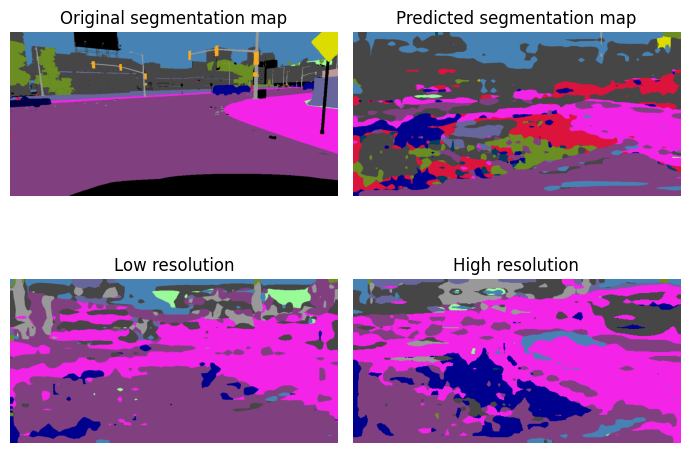

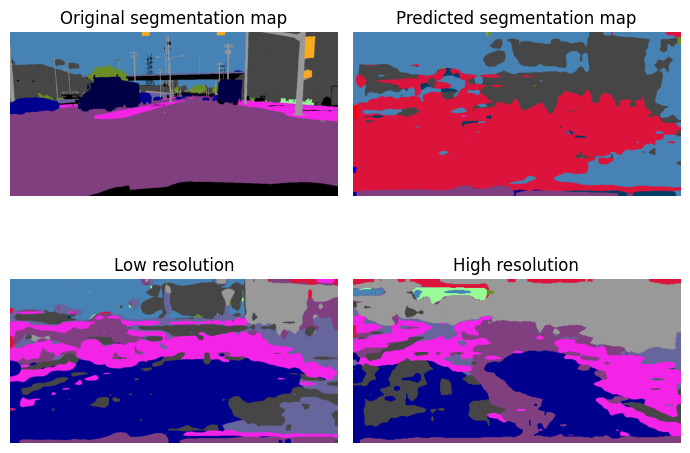

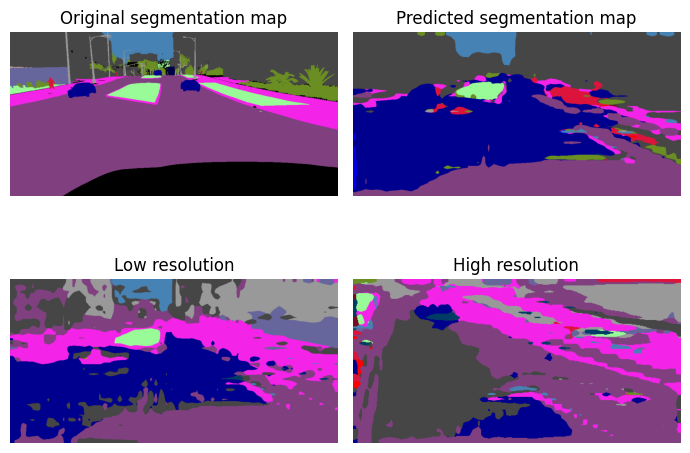

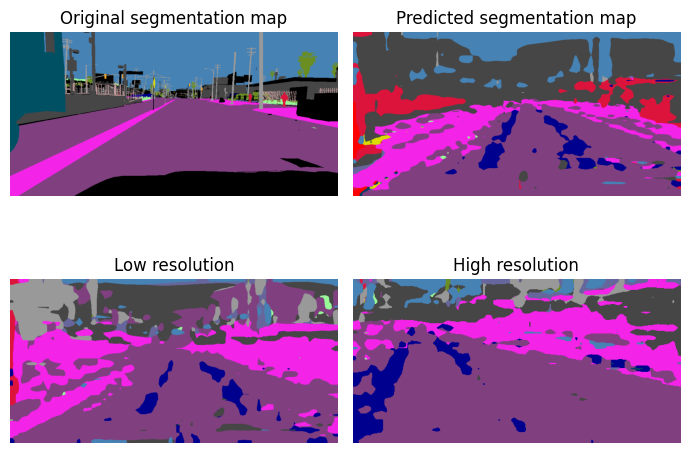

In [34]:
B = 4
H = 512
W = 1024

transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((H,W)),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((H, W), interpolation=v2.InterpolationMode.NEAREST),
])

s = 0.4
custom_augmentation = v2.Compose([
    nn.Identity(),
    # v2.GaussianBlur(7),
    # v2.ColorJitter(brightness=s, contrast=s, saturation=s, hue=s),
    # v2.GaussianNoise(mean=0, sigma=0.05)
])

# data = CityScapes("./Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
# data = CityScapes("./Cityscapes/Cityspaces", split="val", transform=transform, target_transform=target_transform)
data, _ = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=1.0, split_seed=42, augment=False, transform=transform, target_transform=target_transform)

dataloader = DataLoader(data, batch_size=B, shuffle=True)
# dataloader = DataLoader(data, batch_size=B, shuffle=False)

img_tensor, color_tensor, label = next(iter(dataloader))

img_tensor = \
normalize(
    custom_augmentation(
        img_tensor
    )
)

# img_tensor = img_tensor.clamp(0,1)

model:BiSeNetWithHRDA

lr_img, lr_label, hr_img, hr_label, crop_coords = model.hrda_crop(img_tensor.to(device), label.to(device))
fused, (lr_out, hr_out) = model.hrda_forward(lr_img, hr_img, crop_coords)
predicted_labels = fused.detach().argmax(1).cpu()
lr_labels = lr_out.detach().argmax(1).cpu()
hr_labels = hr_out.detach().argmax(1).cpu()

# predicted_labels = model.hrda_eval(
#     img_tensor.to(device)
# ).argmax(1).detach().cpu()

criterion = nn.CrossEntropyLoss(ignore_index=255)

x1, y1, cw, ch = crop_coords

for i in range(B):
    predicted_colors = decode_segmap(predicted_labels[i].numpy())
    lr_colors = decode_segmap(lr_labels[i].numpy())
    hr_colors = decode_segmap(hr_labels[i].numpy())
    true_colors = decode_segmap(label[i, 0].numpy())

    fig, axes = plt.subplot_mosaic(
        """
            AB
            CD
        """,
        figsize=(7,7), layout="tight"
    )
    # fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

    axes["A"].set_title("Original segmentation map")
    # axes["A"].imshow(true_colors[y1:y1+ch, x1:x1+cw])
    axes["A"].imshow(true_colors)
    axes["A"].axis('off')

    axes["B"].set_title("Predicted segmentation map")
    # axes["B"].imshow(predicted_colors[y1:y1+ch, x1:x1+cw])
    axes["B"].imshow(predicted_colors)
    axes["B"].axis('off')

    axes["C"].set_title("Low resolution")
    # axes["C"].imshow(lr_colors[y1:y1+ch, x1:x1+cw])
    axes["C"].imshow(lr_colors)
    axes["C"].axis('off')

    axes["D"].set_title("High resolution")
    axes["D"].imshow(hr_colors)
    axes["D"].axis('off')

    fig.show()


In [ ]:
ENABLE_PRINT = False
ENABLE_WANDB_LOG = False

loss, mIou, mIou_class, _ = validate(model, dataloader, criterion)

print(f"Loss: {loss}\nmIou: {mIou}\nmIou per classe: {mIou_class.tolist()}")

  0%|          | 0/125 [00:00<?, ?it/s]

Loss: 3.3400170640945435
 mIou: 0.11896666884422302
, mIou per classe: [0.24252745509147644, 0.052859604358673096, 0.5206817388534546, 0.01624700054526329, 0.0, 0.002765352837741375, 0.0, 0.0, 0.020420748740434647, 0.0075667607598006725, 0.1374092698097229, 0.0, 0.0, 0.2872229516506195, 0.009759081527590752, 0.011173403821885586, 0.0, 0.0, 0.0]


# Class frequency calculation

In [ ]:
data, _ = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=1.0, split_seed=42, augment=True, transform=v2.ToTensor(), target_transform=v2.ToTensor())
dataloader = DataLoader(data, batch_size=1, shuffle=True)

freqs = torch.zeros(n_classes)

for _,_,label in tqdm(dataloader):
    freqs += torch.bincount(label[label < n_classes].view(-1), minlength=n_classes)[:n_classes]

    # plt.imshow(label[0].repeat(3,1,1).permute(1,2,0))

print(freqs)

In [ ]:
objects = GTA5Labels_TaskCV2017().list_

print("id;name;count")
for i in range(n_classes):
    print(f"{objects[i].ID};{objects[i].name};{freqs[i].item()}")

In [ ]:
import torch
import matplotlib.pyplot as plt

l = [2000279424,157799632,586026240,79183408,31111896,52304620,5818070,5331167,313206784,140294832,734290112,5793555,1213679,100922184,54996872,12020944,15980102,1665942,260148]

a = torch.Tensor(l)

a /= a.sum()

fig, axs= plt.subplots(2,2)

T = [[0.015, 0.02], [0.03, 0.06]]
correction = torch.zeros(19)
for i in range(2):
    for j in range(2):
        b = torch.exp((1-a)/T[i][j])/torch.sum(torch.exp((1-a)/T[i][j]))
    
        axs[i,j].plot(b)

T = [[0.015, 0.02], [0.03, 0.06]]
correction = torch.zeros(19)
for i in range(2):
    for j in range(2):
        b = torch.exp((1-a)/T[i][j])/torch.sum(torch.exp((1-a)/T[i][j]))
        
        correction += 1-b/0.6

        axs[i,j].plot((b+correction)/(b+correction).sum())
        
print(b.sum())
plt.plot(b)